# Quantum control via superoscillations: Tracking wavefunction 

Tracking the wave function, not the unitary propagator

In [1]:
using LinearAlgebra
using PyPlot
using DynamicPolynomials
using JuMP
using NLopt

In [2]:
# Pauli matrices
σx = [0 1
    1 0.]

σy = [0 -im
    im 0.]

σz = [1 0
    0 -1.];

## Target

In [3]:
# dimensionality of the system
N = 2

# The drift hamiltonian
H0_target = σz

# the control Hamiltonian
V_target = σx

# control field -- transform limited
ω₀ = 2.
E₀ = 10

# time
times = range(0, 2 * 2 * π / ω₀, 500)
Δt = times[2] - times[1]

E_target(t) = E₀ * sin(ω₀ * t)

E_target (generic function with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


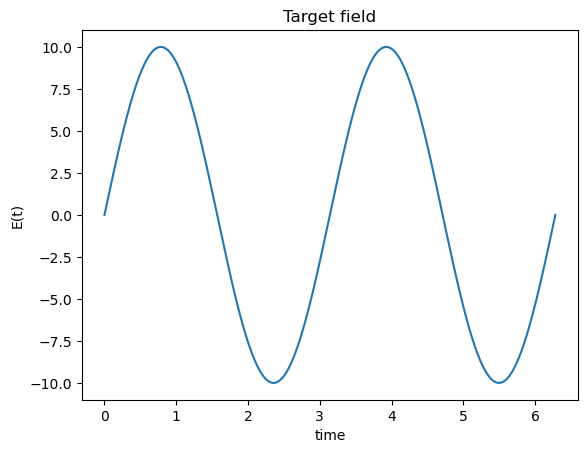

In [4]:
title("Target field")
plot(times, E_target.(times))
xlabel("time")
ylabel("E(t)")

show()

## Controlled system

In [5]:
# the control Hamiltonian
V_ctr = [0 0.9
        0.9 0.1]

# The drift hamiltonian  
H0_ctr = [1 0
        0 -2.]

# Controls field
function E_ctr(t, X)
    n = length(X)
    @assert n % 2 == 0
    
    k = n ÷ 2
    
    # Note using frequencies lower than ω₀, i.e., we want to get the superoscillating control
    Ω = (1:k) * (ω₀ / (2.  * k))
    
    # Using http://dlmf.nist.gov/4.21.E1_5 to parametrize the phase and amplitude
    return sum(
        a * cos(ω * t) + b * sin(ω * t) for (a, b, ω) in zip(X[1:k], X[(k + 1):end], Ω)
    ) 
end

E_ctr (generic function with 1 method)

## Utilities for working with Polynomials

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end
        
function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)#  LN_BOBYQA

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

## Generate the objective functions to find the controls
 
The idea is to find $E_{ctr}(t)$ such that

$$|\Psi_{ctr}(t)\rangle \to |\Psi_{target}(t)\rangle, \quad \forall t.$$

$$
    U_{ctr}(\Delta t (k + 1), \Delta t k) = T \exp\left[ -i \int_{\Delta t k}^{\Delta t (k + 1)} H_{ctr}(\tau)d\tau\right]
$$
$$
    = \exp\left[ -i \Delta t  H_{ctr}(k\Delta t  + \Delta t / 2)\right] + O(\Delta t^3).
$$

Recall
$$
    e^{-iG} = \frac{e^{-iG/2}}{e^{iG/2}} = \frac{1 - iG/2}{1 + iG/2} + O(G^3)
$$

If $G^\dagger = G$ then $\frac{1 - iG/2}{1 + iG/2}$ is unitary. This is known as the Cayley transform. Hence,

$$
    U_{ctr}(\Delta t (k + 1), \Delta t k) = \frac{1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2)} + O(\Delta t^3).
$$

Based on this we can recovered [the Crank-Nicolson method](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method)

$$
    |\Psi_{ctr}(\Delta t (k + 1))\rangle =  U_{ctr}(\Delta t (k + 1), \Delta t k) |\Psi_{ctr}(\Delta t k)\rangle  + O(\Delta t^3) \Longrightarrow
$$

$$
    \Big( 1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{ctr}(\Delta t (k + 1))\rangle = \Big( 1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{ctr}(\Delta t k)\rangle + O(\Delta t^3)
$$

However, since we want $|\Psi_{ctr}(t)\rangle \to |\Psi_{target}(t)\rangle$

$$
    \Big( 1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{target}(\Delta t (k + 1))\rangle = \Big( 1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{target}(\Delta t k)\rangle + O(\Delta t^3)
$$

Hence, we use the following cost function (objective function)

$$
   O = \sum_{k=0} \Big\| \Big( 1 + i(\Delta t/2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{target}(\Delta t (k + 1))\rangle -  \Big( 1 - i(\Delta t / 2)  H_{ctr}(k\Delta t  + \Delta t / 2) \Big) |\Psi_{target}(\Delta t k)\rangle \Big\|^2 \to \min.
$$

In [7]:
@polyvar X[1:10]

(PolyVar{true}[X₁, X₂, X₃, X₄, X₅, X₆, X₇, X₈, X₉, X₁₀],)

## Get $|\Psi_{target}(t)\rangle$

In [8]:
U_target(t) = exp(-im * Δt * Matrix(H0_target + E_target(t) * V_target))
    
ψ₀ = [1; 0]

Ψ_target = zeros(Complex, length(times), length(ψ₀))
Ψ_target[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ_target[k, :] = U_target(Δt * (k - 2) + Δt / 2) * Ψ_target[k - 1, :]
end

## Form the objective function

In [9]:
H_ctr(t, X) = H0_ctr + V_ctr * E_ctr(t, X)

obj = sum(
    square_frobenius_norm(
        (I + im * (Δt / 2) * H_ctr(Δt * (k - 2) + Δt / 2, X)) * (Ψ_target[k, :] .+ 0. * X[1]) - 
        (I - im * (Δt / 2) * H_ctr(Δt * (k - 2) + Δt / 2, X)) * (Ψ_target[k - 1, :] .+ 0. * X[1])
    ) 
    for k in 2:length(times)
);

## Get the control field

In [10]:
found_X = local_minimize(obj, zeros(length(X)))

10-element Vector{Float64}:
  -74.21951411446432
 -131.9837550619721
    2.1187843990462927
  190.5274248147669
   10.148622511145428
  151.4229371094074
   -2.680632219976645
    1.3078449326454382
  303.505275351759
 -219.2256780044528

In [11]:
obj(found_X)

0.260703488658542

Let $U$ be unitary, then
$$
    \| U \|_F^2 = Tr(U U^\dagger) = Tr(1) = N.
$$

Let $U_{1,2}$ be unitaries, then
$$
\| U_1 - U_2 \|_F \leq \| U_1 \|_F + \| U_2 \|_F = 2 \sqrt{N}
$$

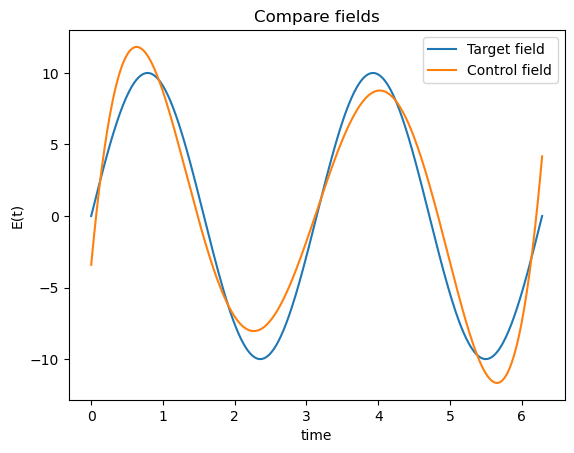

In [12]:
title("Compare fields")
plot(times, E_target.(times), label="Target field")
plot(times, [E_ctr(t, found_X) for t in times], label="Control field")
xlabel("time")
ylabel("E(t)")
legend()

show()

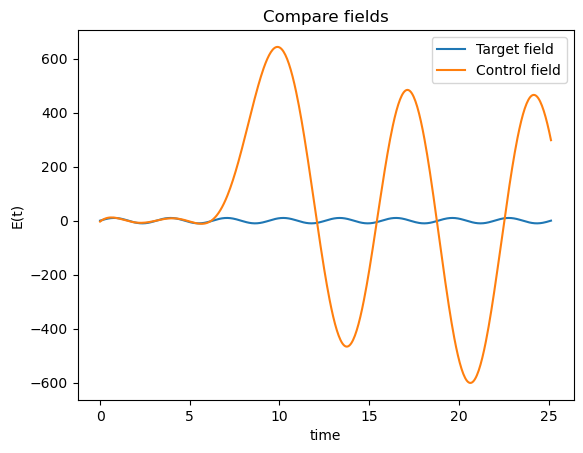

In [13]:
title("Compare fields")

longer_times = 4 * times

plot(longer_times, E_target.(longer_times), label="Target field")
plot(longer_times, [E_ctr(t, found_X) for t in longer_times], label="Control field")
xlabel("time")
ylabel("E(t)")
legend()

show()

## Comparing dynamics for a given initial state

In [14]:
U_ctr(t, X) = exp(-im * Δt * Matrix(H0_ctr + E_ctr(t, X) * V_ctr))
    
Ψ_ctr = zeros(Complex, length(times), length(ψ₀))
Ψ_ctr[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ_ctr[k, :] = U_ctr(Δt * (k - 2) + Δt / 2, found_X) * Ψ_ctr[k - 1, :]
end

In [15]:
nz_target = real.([Ψ_target[k, :]' * σz * Ψ_target[k, :] for k in 1:length(times)])

nz_ctr = real.([Ψ_ctr[k, :]' * σz * Ψ_ctr[k, :] for k in 1:length(times)]);

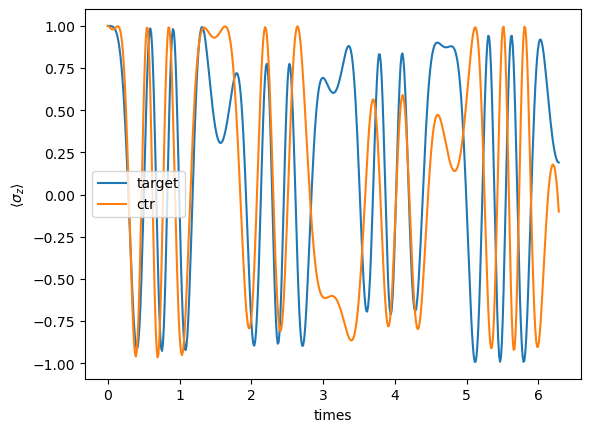

In [16]:
plot(times, nz_target, label="target")
plot(times, nz_ctr, label="ctr")
xlabel("times")
ylabel(L"\langle \sigma_z \rangle")
legend()
show()

## Preliminary conclusion

If we ask to track the wave function, it seems we are getting the same results as tracking the unitary propagator. 

Recall that when tracking the unitary evolution operator, if the control Hamiltonians of control and target systems are similar (congruent?) then the control field tries to preproduce (up to a constant) the filed applied on the target system. In other words, it looks like a linear response.
